In [1]:
# Gene: RNF168 ENSG00000163961
# Transcript ID	Name	bp	Protein	Biotype	CCDS	UniProt Match	RefSeq Match	Flags
# ENST00000318037.3	RNF168-201	5347	571aa	Protein coding
# ENST00000437070.1	RNF168-202	2202	116aa	Nonsense mediated decay

In [2]:
import pandas, numpy
import scipy

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':16, 
                            'font.family':'sans-serif', 
                            'xtick.labelsize':16, 
                            'ytick.labelsize':16, 
                            'figure.figsize':(16*2/3, 9*2/3), 
                            'axes.labelsize':16
                           })

# user-defined variables

In [4]:
control_input_file = '/Users/adrian/research/oskjuhlid/results/inference/inference_control/data.site_proba.csv'
fto_input_file = '/Users/adrian/research/oskjuhlid/results/inference/inference_fto/data.site_proba.csv'

# read information

In [5]:
df_control = pandas.read_csv(control_input_file, sep=',', index_col=0)
df_fto = pandas.read_csv(fto_input_file, sep=',', index_col=0)

print(df_control.shape)
print(df_fto.shape)

(501680, 5)
(793520, 5)


# comparison
each transcript, report as x the mean modification difference and y as the abs sum differential modifications
consider working with probability_modified instead mod_ratio because of quality scores? may need to check/follow up

21912
detected 1171 marks
-0.1 0.1
histo info
200 -0.0995 0.0995


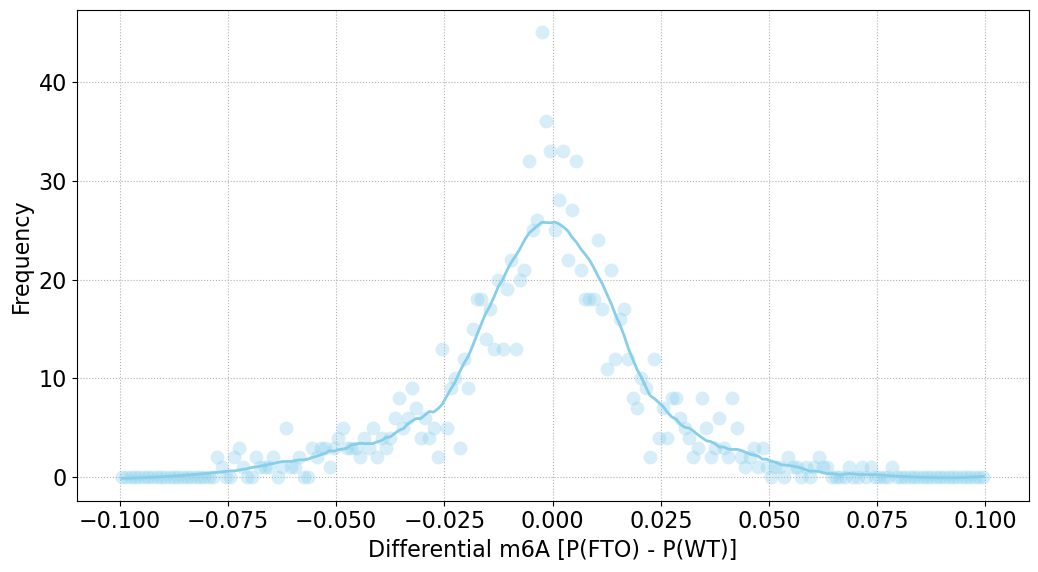

CPU times: user 25 s, sys: 322 ms, total: 25.3 s
Wall time: 25.9 s


In [6]:
%%time

all_transcripts = list(set(df_control.index) & set(df_fto.index))
all_transcripts.sort()
print(len(all_transcripts))

x = []; y = []; z = []

for i in range(int(len(all_transcripts)*0.1)):
    
    transcript = all_transcripts[i]
    
    ss_control = df_control.loc[transcript, ]
    ss_fto = df_fto.loc[transcript, ]

    if (isinstance(ss_control, pandas.DataFrame) == False) | (isinstance(ss_fto, pandas.DataFrame) == False):     
        pass
    else:
        common_locations = list(set(ss_control['transcript_position']) & set(ss_fto['transcript_position']))
        if len(common_locations) < 1:
            pass
        else:
            
            common_locations.sort()
    
            cdf_control = ss_control[ss_control['transcript_position'].isin(common_locations)]
            cdf_fto = ss_fto[ss_fto['transcript_position'].isin(common_locations)]
    
            probs_control = cdf_control['probability_modified'].values
            probs_fto = cdf_fto['probability_modified'].values

            
            for i in range(len(probs_control)):
                if numpy.min([probs_control[i], probs_fto[i]]) > 0.9:
                    difference = probs_fto[i] - probs_control[i]
                    x.append(difference)


low = numpy.min(x)
high = numpy.max(x)
low = -0.1; high = 0.1
resolution = 200
print('detected {} marks'.format(len(x)))
print(low, high)

hist, bin_edges = numpy.histogram(x, bins=resolution, range=(low, high))
half_bin = (bin_edges[1] - bin_edges[0])/2
x = bin_edges + half_bin
x = x[:-1]

print('histo info')
print(len(hist), min(x), max(x))

matplotlib.pyplot.plot(x, hist, 'o', alpha=1/3, color='skyblue', mew=0, markersize=10)

yhat = scipy.signal.savgol_filter(hist, 51, 3)

matplotlib.pyplot.plot(x, yhat, '-', lw=2, alpha=3/3, color='skyblue')

matplotlib.pyplot.xlim(-0.11, 0.11)

matplotlib.pyplot.xlabel('Differential m6A [P(FTO) - P(WT)]')
matplotlib.pyplot.ylabel('Frequency')
matplotlib.pyplot.grid(ls=':', zorder=0)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()         

FTO KD should increase methylation, which is not apparent.

how many marks are in on one wrt to the other. Like a scatter plot for number of marks?

21912
646


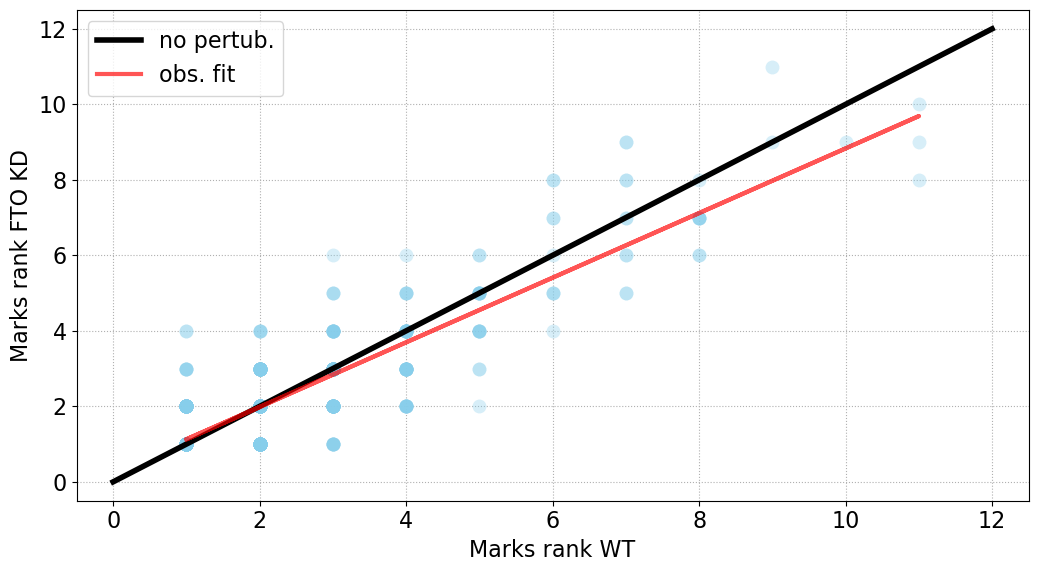

CPU times: user 23.8 s, sys: 182 ms, total: 23.9 s
Wall time: 24.6 s


In [9]:
%%time

all_transcripts = list(set(df_control.index) & set(df_fto.index))
all_transcripts.sort()
print(len(all_transcripts))

vx = []; vy = []

for i in range(int(len(all_transcripts)*1.0)):
    
    x = 0; y = 0    
    transcript = all_transcripts[i]
    
    ss_control = df_control.loc[transcript, ]
    ss_fto = df_fto.loc[transcript, ]

    if (isinstance(ss_control, pandas.DataFrame) == False) | (isinstance(ss_fto, pandas.DataFrame) == False):     
        pass
    else:
        common_locations = list(set(ss_control['transcript_position']) & set(ss_fto['transcript_position']))
        if len(common_locations) < 1:
            pass
        else:
            
            common_locations.sort()
    
            cdf_control = ss_control[ss_control['transcript_position'].isin(common_locations)]
            cdf_fto = ss_fto[ss_fto['transcript_position'].isin(common_locations)]
    
            probs_control = cdf_control['probability_modified'].values
            probs_fto = cdf_fto['probability_modified'].values

            for i in range(len(probs_control)):
                if probs_control[i] > 0.9:
                    x = x + 1
                if probs_fto[i] > 0.9:
                    y = y + 1
    
    # appending if necessary               
    if x != 0:
        if y != 0:
            vx.append(x); vy.append(y)

print(len(vx))
matplotlib.pyplot.plot(vx, vy, 'o', alpha=1/3, color='skyblue', mew=0, markersize=10)
matplotlib.pyplot.plot([0, 12], [0, 12], ls='-', lw=1, color='black', label='no pertub.')

result = scipy.stats.linregress(vx, vy)
yhat = result.slope*numpy.array(vx) + result.intercept
matplotlib.pyplot.plot(vx, yhat, ls='-', lw=3, color='red', label='obs. fit', alpha=2/3)

matplotlib.pyplot.xlim(-0.5, 12.5)
matplotlib.pyplot.ylim(-0.5, 12.5)

matplotlib.pyplot.xlabel('Marks rank WT')
matplotlib.pyplot.ylabel('Marks rank FTO KD')
matplotlib.pyplot.legend()
matplotlib.pyplot.grid(ls=':', zorder=0)
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()         